In [36]:
# Importing the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,KFold
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix,recall_score,precision_score,classification_report,roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle

import xgboost as xgb
# from xgboost.sklearn import XGBClassifier

from scipy.stats import boxcox

import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk import tokenize
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

from wordcloud import WordCloud

from joblib import dump, load
import pickle

import string
import re
import time

# pip install pandas-profiling 
# from pandas_profiling import ProfileReport

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rajasekhar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [37]:
#Importing dataset
data=pd.read_csv('training.1600000.processed.noemoticon.csv',encoding='ISO-8859-1')
data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [38]:
# Renaming the columns of dataset
data.columns=['sentiment','time','date','query','username','text']

In [39]:
# Displaying the dataset after renaming columns
data.head()

,sentiment,time,date,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [40]:
# Observing the datatypes and no of null values in each columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1599999 non-null  int64 
 1   time       1599999 non-null  int64 
 2   date       1599999 non-null  object
 3   query      1599999 non-null  object
 4   username   1599999 non-null  object
 5   text       1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


sentiment,time are integer datatype.Remaining all are object datatype.No column is containing null values

In [41]:
# value counts in sentiment column
data['sentiment'].value_counts()

4    800000
0    799999
Name: sentiment, dtype: int64

sentiment column contains 800000 '4' values & 799999 '0' values (equal distribution)

<AxesSubplot:>

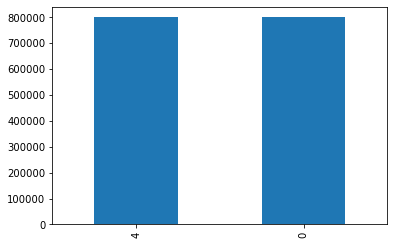

In [42]:
# Representing sentiment column distribution in barplot
data['sentiment'].value_counts().plot.bar()

# Data Preparation

In [43]:
# displaying the data of sentiment & text columns
dataset=data[['sentiment','text']]
dataset.head()

,sentiment,text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


In [44]:
# converting the positive sentiment value '4' to '1' for better understanding
dataset['sentiment']=dataset['sentiment'].map(lambda x:1 if x==4 else x)

In [45]:
# displaying the dataset post conversion of positive sentiment value
dataset.head()

,sentiment,text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


In [46]:
# storing sentiment & text data in list for further processing
sentiment,text=list(dataset['sentiment']),list(dataset['text'])

# Data Preprocessing

In [47]:
# Defined a method with all preprocessing functions

def preprocess(textdata):
    
    # Defining dictionary containing all emojis with their meanings.
    emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
              ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
              ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
              ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
              '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
              '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
              ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

    stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
                 'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
                 'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
                 'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
                 'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
                 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
                 'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
                 'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
                 'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
                 's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
                 't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
                 'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
                 'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
                 'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
                 'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
                 "youve", 'your', 'yours', 'yourself', 'yourselves']
    processedText = []
        
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    # alphaPattern      = "[^a-zA-Z0-9]"
    alphaPattern      = "[^a-zA-Z]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])    
            
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)  
        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        
        #Removing punctuations if any left post removing all all non alphabets
        all_char_list = []
        all_char_list = [char for char in tweet if char not in string.punctuation]
        tweet = ''.join(all_char_list)
        
        # Removing all stopwords as per custom list defined above
        tweetwords = ''
        for word in tweet.split():
            if word not in (stopwordlist):
                if len(word)>1:
                    # Lemmatizing the word.
                    # text_pos = pos_tag(word_tokenize(word))
                    # word = lemma.lemmatize(text_pos[0][0],get_wordnet_pos_tag(text_pos[0][1]))
                    # word = wordLemm.lemmatize(word)
                    tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText
preprocessedtext = preprocess(text)

In [48]:
preprocessedtext

['upset update facebook texting might cry result school today also blah ',
 'USER dived many times ball managed save rest go bounds ',
 'whole body feels itchy like fire ',
 'USER no not behaving mad see over ',
 'USER not whole crew ',
 'need hug ',
 'USER hey long time no see yes rains bit bit lol fine thanks ',
 'USER nope didn ',
 'USER que muera ',
 'spring break plain city snowing ',
 'pierced ears ',
 'USER couldn bear watch thought ua loss embarrassing ',
 'USER counts idk either never talk anymore ',
 'USER would first but didn gun not really though zac snyder doucheclown ',
 'USER wish got watch miss USER premiere ',
 'hollis death scene hurt severely watch film wry directors cut not ',
 'file taxes ',
 'USER ahh ive always wanted see rent love soundtrack ',
 'USER oh dear drinking forgotten table drinks ',
 'USER day didn get much done ',
 'one friend called asked meet mid valley today but no time sigh ',
 'USER baked cake but ated ',
 'week not going hoped ',
 'blagh class 

In [49]:
after_tokens=[]
for i in preprocessedtext:
    tokens=[]
    for j in i.split(' '):
        tokens.append(j)
    after_tokens.append(tokens)

In [50]:
after_tokens

[['upset',
  'update',
  'facebook',
  'texting',
  'might',
  'cry',
  'result',
  'school',
  'today',
  'also',
  'blah',
  ''],
 ['USER',
  'dived',
  'many',
  'times',
  'ball',
  'managed',
  'save',
  'rest',
  'go',
  'bounds',
  ''],
 ['whole', 'body', 'feels', 'itchy', 'like', 'fire', ''],
 ['USER', 'no', 'not', 'behaving', 'mad', 'see', 'over', ''],
 ['USER', 'not', 'whole', 'crew', ''],
 ['need', 'hug', ''],
 ['USER',
  'hey',
  'long',
  'time',
  'no',
  'see',
  'yes',
  'rains',
  'bit',
  'bit',
  'lol',
  'fine',
  'thanks',
  ''],
 ['USER', 'nope', 'didn', ''],
 ['USER', 'que', 'muera', ''],
 ['spring', 'break', 'plain', 'city', 'snowing', ''],
 ['pierced', 'ears', ''],
 ['USER',
  'couldn',
  'bear',
  'watch',
  'thought',
  'ua',
  'loss',
  'embarrassing',
  ''],
 ['USER', 'counts', 'idk', 'either', 'never', 'talk', 'anymore', ''],
 ['USER',
  'would',
  'first',
  'but',
  'didn',
  'gun',
  'not',
  'really',
  'though',
  'zac',
  'snyder',
  'doucheclown',
 

In [51]:
lemma=nltk.WordNetLemmatizer()
finalpreprocessedtext=[]
for i in after_tokens:
    text=" ".join([lemma.lemmatize(word) for word in i])
    finalpreprocessedtext.append(text)
    

In [52]:
finalpreprocessedtext

['upset update facebook texting might cry result school today also blah ',
 'USER dived many time ball managed save rest go bound ',
 'whole body feel itchy like fire ',
 'USER no not behaving mad see over ',
 'USER not whole crew ',
 'need hug ',
 'USER hey long time no see yes rain bit bit lol fine thanks ',
 'USER nope didn ',
 'USER que muera ',
 'spring break plain city snowing ',
 'pierced ear ',
 'USER couldn bear watch thought ua loss embarrassing ',
 'USER count idk either never talk anymore ',
 'USER would first but didn gun not really though zac snyder doucheclown ',
 'USER wish got watch miss USER premiere ',
 'hollis death scene hurt severely watch film wry director cut not ',
 'file tax ',
 'USER ahh ive always wanted see rent love soundtrack ',
 'USER oh dear drinking forgotten table drink ',
 'USER day didn get much done ',
 'one friend called asked meet mid valley today but no time sigh ',
 'USER baked cake but ated ',
 'week not going hoped ',
 'blagh class tomorrow '

# Data Analysis

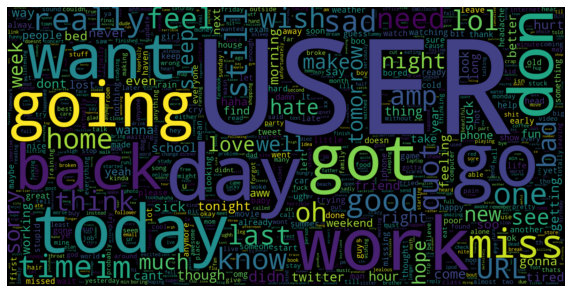

In [53]:
# Creating word cloud of negative tweets, where the words appearing larger are more frequent in nature across articles
# First 800000 tweets in the list are negative tweets

data_neg = finalpreprocessedtext[:800000]
all_negwords = ' '.join(data_neg)
wordcloud = WordCloud(max_words = 1000, width= 1600, height= 800,
                      collocations = False).generate(all_negwords)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

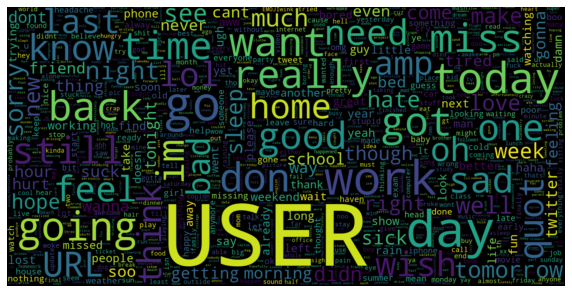

In [54]:
# Creating word cloud of positive tweets, where the words appearing larger are more frequent in nature acros articles
# Last 800000 tweets in the list are negative tweets

data_pos = finalpreprocessedtext[800000:]
all_poswords = ' '.join(data_pos)
wordcloud = WordCloud(max_words = 1000, width= 1600, height= 800,
                      collocations = False).generate(all_negwords)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [55]:
# Created a method using WhitespaceTokenizer and FreqDist to identify the most frequent set of words in the datset segregated
# by target variable

token_wspace = tokenize.WhitespaceTokenizer()

def mostFrequentWords(tweets,quantity):
    all_words = ' '.join(tweets)
    all_tokens = token_wspace.tokenize(all_words)
    freq_dist = nltk.FreqDist(all_tokens)
    df_frequency = pd.DataFrame({"Word":list(freq_dist.keys()), "Frequency":list(freq_dist.values())})
    df_frequency = df_frequency.nlargest(columns="Frequency", n=quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

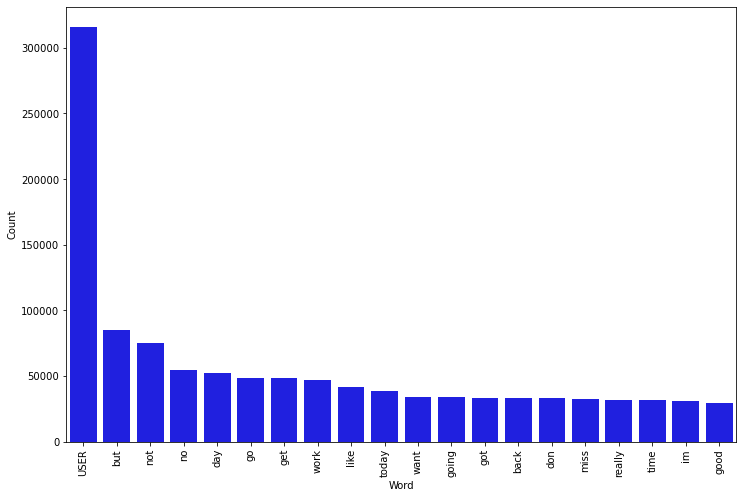

In [56]:
# Calling the above method for negative cases, plotting the most frequent top 20 words
mostFrequentWords(finalpreprocessedtext[:800000],20)

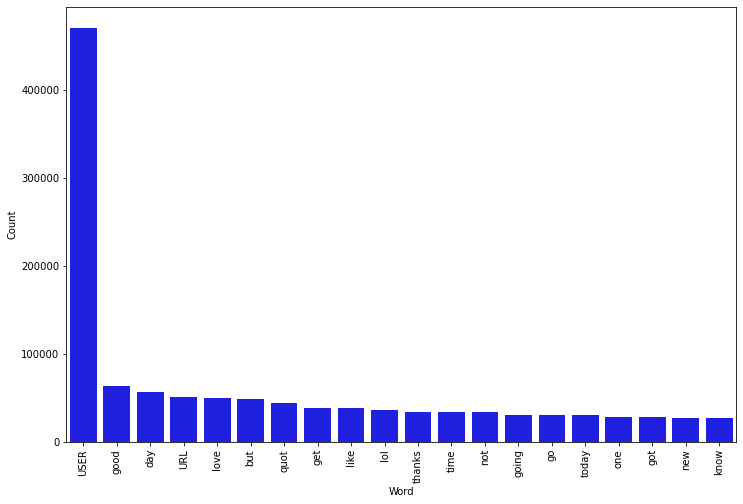

In [57]:
# Calling the above method for positive cases, plotting the most frequent top 20 words
mostFrequentWords(finalpreprocessedtext[800000:],20)

# Splitting the Data

In [58]:
# Splitting the entire set into train and test with test size of 5%
X_train, X_test, y_train, y_test = train_test_split(finalpreprocessedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)
print('Data Split done..')

Data Split done..


# tf-idf vectorizer

In [59]:
# Fitting TFIDF vectorizer on the train dataset 
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  500000


# Transforming the dataset

In [60]:
# Transforming the X_train and X_test dataset on the fitted model
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


# Creating & evaluating models

In [61]:
# Creating a method which will take the model object and then predict on the test set and evaluate on Accuracy, 
# Confusion Matrix and ROC Curve

def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    
    
    plt.title ("ROC Curve")
    #Area under Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC CURVE')
    plt.legend(loc="lower right")
    plt.show()
    
    return y_pred

# SVC Model

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     39986
           1       0.80      0.81      0.80     40014

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



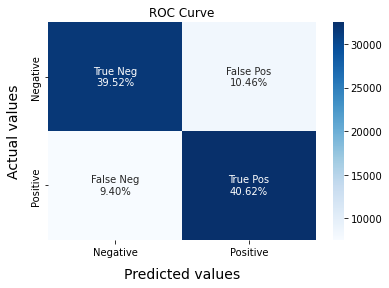

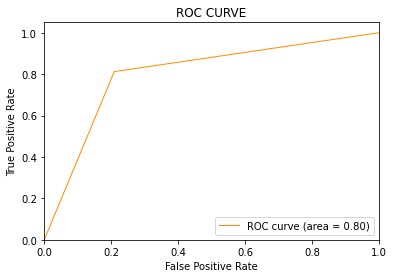

array([1, 1, 0, ..., 0, 1, 1])

In [62]:
# Created a Linear SVM model with default parameters and then evaluating the model

SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

# BernouliNB model

              precision    recall  f1-score   support

           0       0.80      0.79      0.79     39986
           1       0.79      0.81      0.80     40014

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



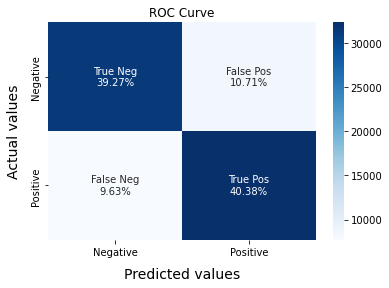

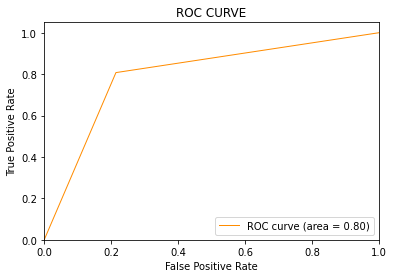

array([1, 1, 0, ..., 1, 1, 0])

In [63]:
# Created a Bernoulli Naive Bayes model with default parameters and then evaluating the model

BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

# Logistic Regression model

              precision    recall  f1-score   support

           0       0.82      0.80      0.81     39986
           1       0.81      0.83      0.82     40014

    accuracy                           0.81     80000
   macro avg       0.81      0.81      0.81     80000
weighted avg       0.81      0.81      0.81     80000



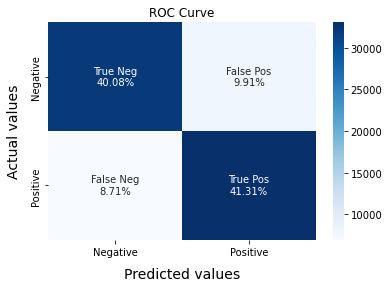

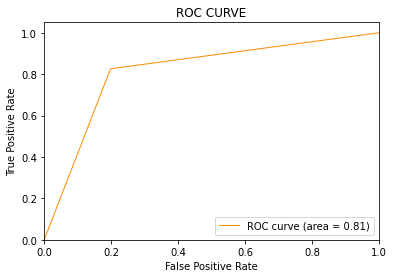

In [64]:
# Created a Logistic Regression model with regularization parameter and max iteration limit and then evaluating the model
LRmodel = LogisticRegression(C = 1, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
y_test_pred = model_Evaluate(LRmodel)

In [65]:
# Printing the positive and negative sentiment on the test data based on logistic regression model
print("Positive Sentiment Percentage : {}%".format(round(np.count_nonzero(y_test_pred == 1)/len(y_test_pred)*100,2)))

print("Negative Sentiment Percentage : {}%".format(round(np.count_nonzero(y_test_pred == 0)/len(y_test_pred)*100,2)))

Positive Sentiment Percentage : 51.22%
Negative Sentiment Percentage : 48.78%


# Saving the model

In [66]:
# Storing the vectorizer object and Logistic Regression object in pickle files for later use

file = open('vectoriser.pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

# Using the model

In [70]:
# Created a method to load the models from pickle file
def load_models():  
       
    # Load the vectoriser.
    file = open('vectoriser.pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    
    # Load the LR Model.
    file = open('Sentiment-LR.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return vectoriser, LRmodel


# Created a method to perform tfidf vectorizer on unseen data and then using the model loaded from pickle file to predict 
# whether positive or negative and also the probability along with it.
# Do note the unseen data should be passed to the model in a list
def predict(vectoriser, model, text):
    finaldata = []
    after_tokens=[]
    for i in text:
        tokens=[]
        for j in i.split(' '):
            tokens.append(j)
        after_tokens.append(tokens)
    lemma=nltk.WordNetLemmatizer()
    finalpreprocessedtext=[]
    for i in after_tokens:
        text2=" ".join([lemma.lemmatize(word) for word in i])
        finalpreprocessedtext.append(text2)
    textdata = vectoriser.transform(finalpreprocessedtext)
    sentiment = model.predict(textdata)
    
    # print(model.classes_)
    sentiment_prob = model.predict_proba(textdata)
    
    for index,tweet in enumerate(text):
        if sentiment[index] == 1:
            sentiment_probFinal = sentiment_prob[index][1]
        else:
            sentiment_probFinal = sentiment_prob[index][0]
            
        sentiment_probFinal2 = "{}%".format(round(sentiment_probFinal*100,2))
        finaldata.append((tweet, sentiment[index], sentiment_probFinal2))
           
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(finaldata, columns = ['tweet','sentiment', 'Probability(Confidence Level)'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

In [68]:
# Text to classify should be in a list.
text = ["I hate twitter",
        "I do not like the movie",
        "Mr. Stark, I don't feel so good",
        "May the Force be with you.",
       "I read the book, the content is not good",
       "This is a new beginning for us"]

In [71]:
# Calling the load model method and then calling predict method by passing the tfidf vectorizer and model as parameter
# Finally printing the dataframe containing tweet, sentiment and the probability confidence.
vectoriser, LRmodel = load_models()
df = predict(vectoriser, LRmodel, text)
df

,tweet,sentiment,Probability(Confidence Level)
0,I hate twitter,Negative,93.92%
1,I do not like the movie,Negative,64.39%
2,"Mr. Stark, I don't feel so good",Negative,59.83%
3,May the Force be with you.,Positive,69.14%
4,"I read the book, the content is not good",Negative,85.62%
5,This is a new beginning for us,Positive,83.14%


# Using the model by giving test dataset

In [72]:
# Importing the dataset
data = pd.read_csv("testdata.csv", encoding = "ISO-8859-1")
data.head()

,url,date,text
0,https://twitter.com/EcoLisa_/status/9022754290...,Mon Aug 28 21:03:20 2017,Here's how you can help victims of #HurricaneH...
1,https://twitter.com/RedefiningDecor/status/903...,Thu Aug 31 15:43:15 2017,RT @tripgabriel: This is a very gripping graph...
2,https://twitter.com/BestofY00/status/903281998...,Thu Aug 31 15:43:05 2017,RT @tripgabriel: This is a very gripping graph...
3,https://twitter.com/Deborah9111966/status/9032...,Thu Aug 31 15:43:01 2017,RT @tripgabriel: This is a very gripping graph...
4,https://twitter.com/kirkbocchi/status/90328194...,Thu Aug 31 15:42:53 2017,RT @tripgabriel: This is a very gripping graph...


In [73]:
data.shape

(15428, 3)

# Storing text data in lists for further processing

In [74]:
text = list(data['text'])

In [75]:
# Created a method to perform tfidf vectorizer on unseen data and then using the model loaded from pickle file to predict 
# whether positive or negative and also the probability along with it.
# Do note the unseen data should be passed to the model in a list
def predict_Excel(vectoriser, model, text):
    finaldata = []
    for i in text:
        tokens=[]
        for j in i.split(' '):
            tokens.append(j)
        after_tokens.append(tokens)
    lemma=nltk.WordNetLemmatizer()
    finalpreprocessedtext=[]
    for i in after_tokens:
        text2=" ".join([lemma.lemmatize(word) for word in i])
        finalpreprocessedtext.append(text2)

    textdata = vectoriser.transform(finalpreprocessedtext)
    sentiment = model.predict(textdata)
    
    # print(model.classes_)
    sentiment_prob = model.predict_proba(textdata)
    
    for index,tweet in enumerate(text):
        sentiment_probFinal = sentiment_prob[index][0]
            
        sentiment_probFinal2 = "{}%".format(round(sentiment_probFinal*100,2))
        finaldata.append((tweet, sentiment[index], sentiment_probFinal2))
           
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(finaldata, columns = ['tweet','sentiment', 'Severity'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

In [76]:
vectoriser, LRmodel = load_models()
df = predict_Excel(vectoriser, LRmodel, text)

In [77]:
df.sort_values(by=['Severity'],ascending=False,inplace=True)
df

,tweet,sentiment,Severity
9562,RT @linksteroh: This is heart breaking! Thousa...,Negative,99.99%
6995,RT @MissDahlELama: Wanna help Houston classroo...,Negative,99.99%
11518,RT @RWPUSA: Our friends to the south are there...,Negative,99.99%
12758,SCDNR Deploys Officers to Texas Coast for Hurr...,Negative,99.99%
6581,RT @HoustonChron: Blink-182 creates Houston Re...,Negative,99.99%
...,...,...,...
9539,Houston Flood Relief Fund https://t.co/HjbRJz...,Positive,1.07%
13510,Mexican bakers in Texas were trapped inside fo...,Positive,0.98%
8694,@lavinator1 Yup! Here it is https://t.co/FlMLh...,Positive,0.66%
8806,RT @Im_TheAntiTrump: Harvey: Muslim youth grou...,Positive,0.39%


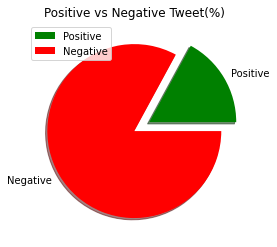

In [78]:
positive = round(np.count_nonzero(df['sentiment'] == "Positive")/len(df['sentiment'])*100,2)
negative = round(np.count_nonzero(df['sentiment'] == "Negative")/len(df['sentiment'])*100,2)

labels = ['Positive','Negative']
values = np.array([positive,negative])
myexplode = [0.2, 0]
mycolors = ["green", "red"]

fig,ax = plt.subplots()
ax.pie(values, labels = labels, explode = myexplode, shadow = True, colors = mycolors)
ax.legend()
ax.set_title("Positive vs Negative Tweet(%)")
fig.show()